In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train_bbnet import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

import time 

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False):
    dataset.is_test = False
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

5000
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1. Create a training target for occlusion edges (boundaries)

In [13]:
IM = targets.IsMovingTarget(
    warp_radius=3,
    thresh=None,
    get_errors=False,
    normalize_features=False,
    warp_dilation=1
).cuda()

def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([2, 3, 512, 512])


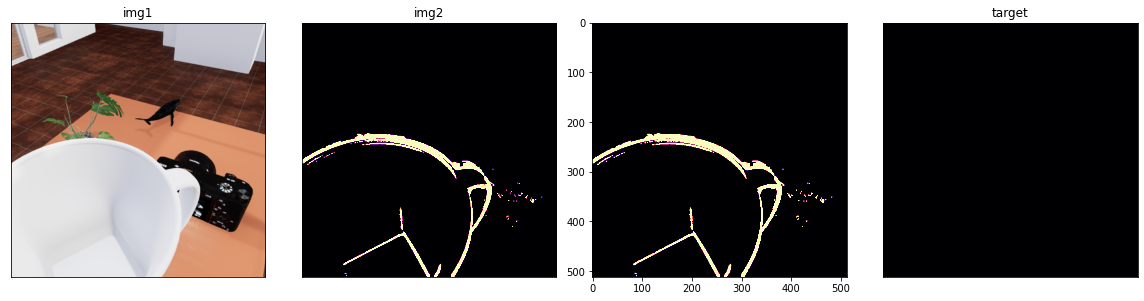

In [14]:
ex = 21
thresh = 0.5
IM.thresh = thresh
tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = True
data = tdw_dataset[ex]
video = torch.stack([x.cuda() for x in [data[0], data[1]]], 0) / 255.
# mask = (data[2][None].float().abs().sum(1, True) > 0).float().cuda()
print(video.shape)
# video = video + torch.randn(video.shape).cuda() * 0.1 * mask
IM.get_errors = False
target = IM(get_patches(video[None], radius=0))
fig, axes = plt.subplots(1,4,figsize=(16,4))
titles = ['img1', 'img2', 'img0', 'target']
for i in range(2):
    vis_utils.imshow(data[i][None] / 255., axes[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(titles[i])
# vis_utils.imshow(zscore(F.relu(target[0])), axes[1], cmap='magma', vmin=0, vmax=thresh)
thresh = 1.0
vis_utils.imshow(target[0], axes[1], cmap='magma', vmin=0, vmax=0.25)
mask = (zscore(F.relu(target[0])) > thresh).float()
vis_utils.imshow(zscore(F.relu(target[0])) * mask, axes[2], cmap='magma', vmin=0, vmax=thresh)
vis_utils.imshow(zscore(F.relu(target[0])) * (1-mask), axes[3], cmap='magma', vmin=0, vmax=thresh)
# vis_utils.imshow(F.relu(target[0]) > 0.0025, axes[3])
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title(titles[3])
plt.tight_layout()
plt.show()

In [15]:
DTarg = fprop.DiffusionTarget(
    radius=1, 
    start_level=0,
    num_levels=4, 
    num_samples=32, 
    max_energy=4,
    num_points=3).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
thresh = 0.25
# ctarget = DTarg(video[None], target[:,0])
ctarget = DTarg(video[None], (zscore(F.relu(target[:,0])) > 10.0).float())


# _, preds = mclass_net(video[1:2] * 255., video[2:3] * 255., test_mode=True, iters=12)
# ctarget = DTarg(preds.sigmoid(), (preds.sigmoid() > thresh).float())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


target tensor(0., device='cuda:0') tensor(1., device='cuda:0')
target tensor(0., device='cuda:0') tensor(1.6250, device='cuda:0')
target tensor(0., device='cuda:0') tensor(1.7884, device='cuda:0')
target tensor(0., device='cuda:0') tensor(1.9550, device='cuda:0')


In [565]:
# fig, axes = plt.subplots(1,len(DTarg.confs), figsize=(16,4*len(DTarg.confs)))
# for i,conf in enumerate(DTarg.confs):
#     if conf is not None:
#         vis_utils.imshow(conf, axes[i], cmap='inferno', vmin=0, vmax=1.0)
#     axes[i].set_title('boundary conf at level %d' % i, fontsize=18)
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
# plt.tight_layout()
# plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


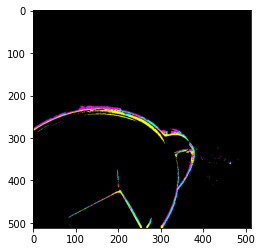

In [566]:
ctarget = ctarget / ctarget.sum(1, True).clamp(min=1e-3)
cflow = fprop.temporal_affinities_to_flows(ctarget.view(1,ctarget.shape[1],-1).transpose(1,2),
                                           size=[512,512])
cflow_rgb = data_utils.FlowToRgb(max_speed=0.01)(cflow)
vis_utils.imshow(cflow_rgb * target[:,0])
# vis_utils.imshow(cflow_rgb * (preds.sigmoid() > thresh).float())

In [430]:
(ctarget * target[:,0]).amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.1336, device='cuda:0')

In [179]:
DProp = fprop.DiffusionPropagator(
    num_iters=2,
    source_thresh=1.0,
    conduction_rate=2,
    diffusion_rate=10,
    interior_radius=1,
    radius=5, 
    start_level=1,
    num_levels=6, 
    num_samples=32, 
    max_energy=4,
    num_points=3,
    eta=0.5,
    downsample_factor=1
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
preds = DProp(video[None])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


target tensor(0., device='cuda:0') tensor(0., device='cuda:0')
target tensor(0., device='cuda:0') tensor(0.3604, device='cuda:0')
target tensor(0., device='cuda:0') tensor(0.4189, device='cuda:0')
target tensor(0., device='cuda:0') tensor(0.4384, device='cuda:0')
target tensor(0., device='cuda:0') tensor(0.5524, device='cuda:0')
target tensor(0., device='cuda:0') tensor(0.6469, device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


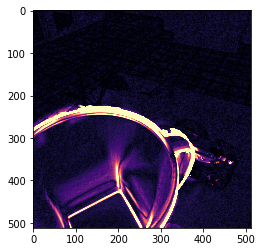

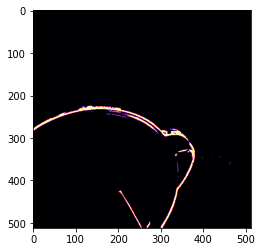

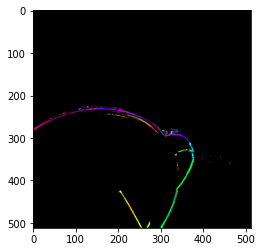

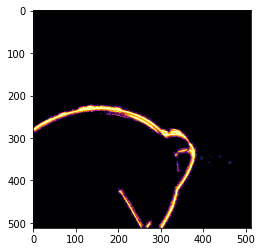

In [182]:
vis_utils.imshow(preds[0], cmap='magma', vmin=0, vmax=0.025)
vis_utils.imshow(preds[1], cmap='magma', vmin=0, vmax=1.0)

cflow = fprop.temporal_affinities_to_flows(preds[2].view(1,preds[2].shape[1],-1).transpose(1,2),
                                           size=[512,512])
cflow_rgb = data_utils.FlowToRgb(max_speed=0.5)(cflow * preds[1])
vis_utils.imshow(cflow_rgb)
vis_utils.imshow(preds[3][-1], cmap='inferno', vmin=0, vmax=1.0)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


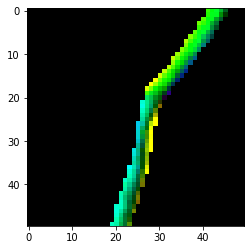

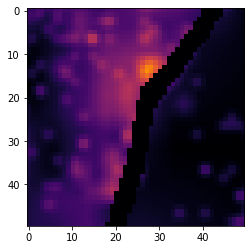

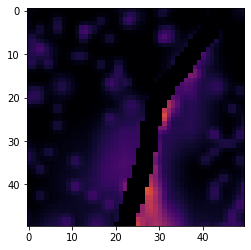

In [183]:
vis_utils.imshow(cflow_rgb[:,:,400:450,310:360])
vis_utils.imshow(preds[2][:,61,None,400:450,310:360], cmap='inferno', vmin=0, vmax=0.05)
vis_utils.imshow(preds[2][:,59,None,400:450,310:360], cmap='inferno', vmin=0, vmax=0.05)
# lr_ratio = preds[2][:,61] / preds[2][:,59].clamp(min=1e-9)
# vis_utils.imshow(lr_ratio[:,None,400:450,310:360])
# vis_utils.imshow(preds[2][:,:,420,335].view(1,1,11,11))
# vis_utils.imshow(preds[2][:,:,425,335].view(1,1,11,11))
# vis_utils.imshow(preds[2][:,:,420,340].view(1,1,11,11))
# vis_utils.imshow(preds[2][:,:,420,342].view(1,1,11,11))



# vis_utils.imshow(preds[2][:,:,420,342].view(1,1,11,11))


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


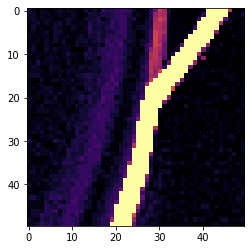

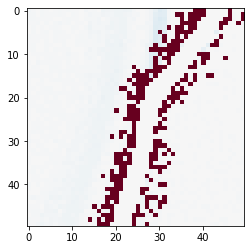

In [184]:
hs = preds[3]
i = 1
vis_utils.imshow((hs[0])[:,:,400:450,310:360], cmap='inferno', vmin=0, vmax=0.1)
vis_utils.imshow((hs[i] - hs[i-1])[:,:,400:450,310:360], cmap='RdBu_r', vmin=-0.2, vmax=0.2)

In [107]:
torch.unique(hs[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([0.0000, 0.5000, 2.0000], device='cuda:0')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


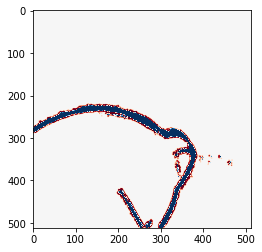

In [83]:
hs = preds[3]
i = -1
vis_utils.imshow(hs[i] - hs[i-1], cmap='RdBu_r', vmin=-0.2, vmax=0.2)

In [596]:
M2S = fprop.MotionToStaticTarget(
    local_radius=1,
    num_initial_points=16,
    refractory=False,
    chain_factor=2,
    size=[128,128]
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [597]:
_, preds = mclass_net(video[0:1] * 255., video[1:2] * 255., test_mode=True, iters=24)
_, _, static_target = M2S(preds)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


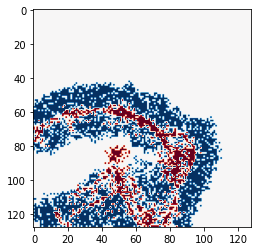

In [598]:
vis_utils.imshow(static_target, cmap='RdBu_r', vmin=-1, vmax=1)

#### Occlusions are places where in one direction errors_s > errors_m, but in the other not

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


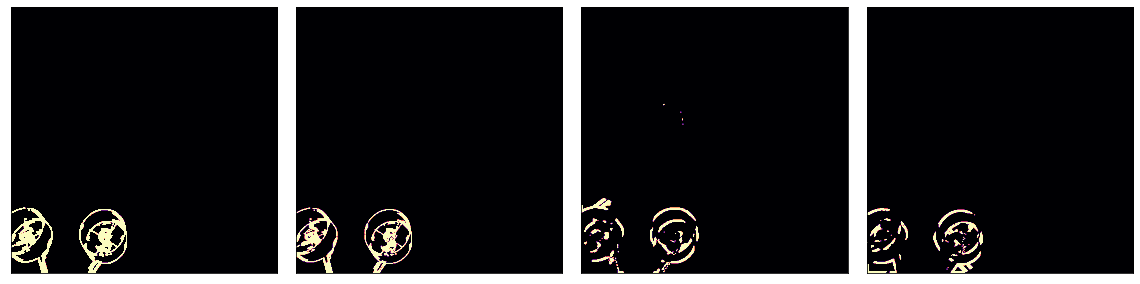

In [221]:
ediff = lambda e: e[:,:,0:1] - e[:,:,1:2]
edges = lambda x: competition.get_gradient_image(x).abs().sum(2)
zdiff = lambda x: zscore(ediff(F.relu(x)))

IM.get_errors = True
errors = IM(video[None])
errors_fwd, errors_bck = errors.split([1,1], 0)
zfwd = zdiff(errors_fwd)[0]
zbck = zdiff(errors_bck)[0]

ofwd = (zfwd > 1.0).float() * (zbck < -0.0).float()
obck = (zbck > 1.0).float() * (zfwd < -0.0).float()


ztarg = zscore(F.relu(target[0]))
ztarg_inv = zscore(F.relu(-target[0]))
zedge = edges((ztarg > 0.1).float())

fig, axes = plt.subplots(1,4,figsize=(16,4))
plots = [
    ztarg,
    (ztarg > 1.),
    ofwd,
    obck
#     ztarg > 0.1,
#     ztarg > 0.01
]
titles = ['t_fwd', 't_bck', 'both', 'not equal']

for i,ax in enumerate(axes):
    vis_utils.imshow(plots[i], ax, cmap='magma', vmin=0, vmax=0.25)
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_title(titles[i])
plt.tight_layout()
plt.show()

In [458]:
!ls ../checkpoints/*zthr*

../checkpoints/10000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/10000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/15000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/15000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/20000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/20000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/25000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/25000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/30000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/30000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/35000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/35000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/40000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
../checkpoints/40000_motion-rnd0-tdw-bs4-small-fullplay-zthr1.pth
../checkpoints/45000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth
..

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [461]:
motion_path = '../checkpoints/45000_motion-rnd0-tdw-bs4-small-fullplay-zthr02.pth'

mclass_net = load_model(
                       motion_path,
                       small=True, 
                       cuda=True, 
                       train=False)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

<All keys matched successfully> MotionClassifier
1595667


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


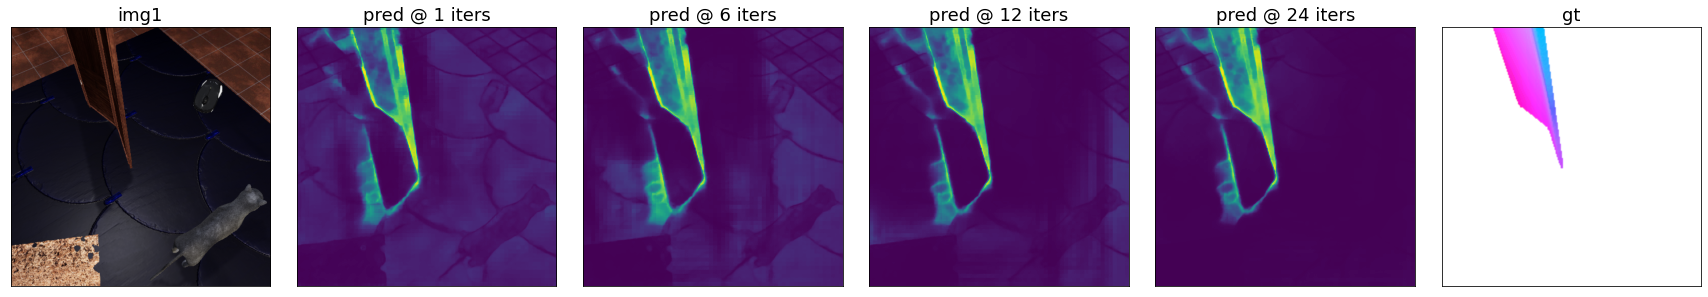

In [466]:
ex = 100
viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=None)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


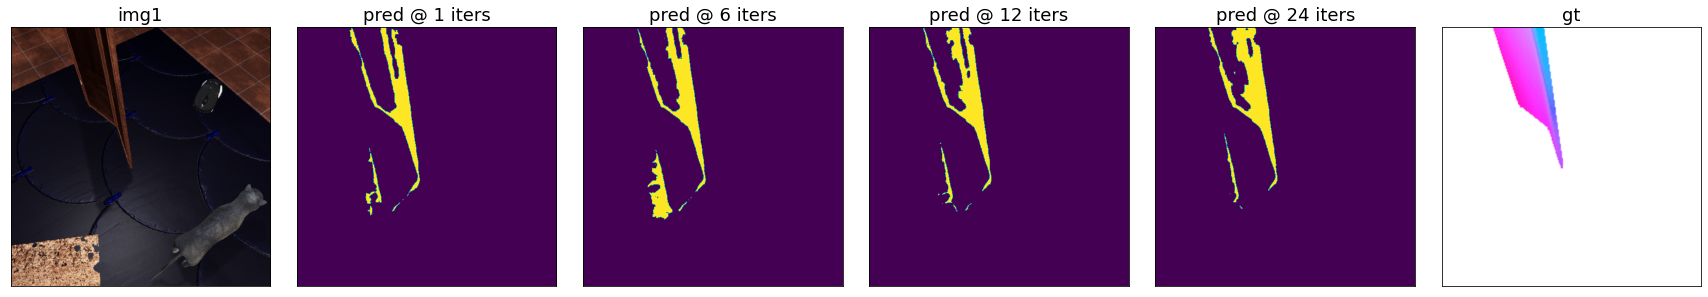

In [467]:
viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=0.5)

In [473]:
_, preds = mclass_net(video[1:2] * 255., video[2:3] * 255., test_mode=True, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


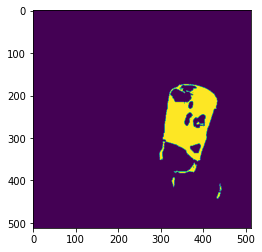

In [475]:
vis_utils.imshow(preds.sigmoid() > 0.5) 

# Implement parts of diffusionRNN one at a time

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


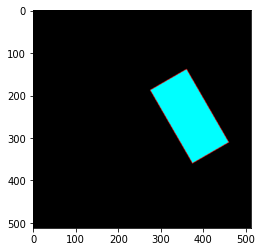

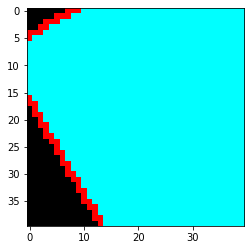

In [233]:
def rectangle(imsize=[512,512], height=200, width=100, offset=[0,0], rotation=0):
    im = torch.zeros([1,1,*imsize]).float()
    h, w = height // 2, width // 2
    ch, cw = [offset[0] + imsize[0]//2, offset[1] + imsize[1]//2]
    hmin, hmax = max(ch-h, 0), min(ch+h, imsize[0])
    wmin, wmax = max(cw-w, 0), min(cw+w, imsize[1])
    im[:,:,hmin:hmax,wmin:wmax] = 1.0
    if rotation != 0:
        im = transforms.RandomRotation((rotation,rotation))(im)
    return im

# vis_utils.imshow(rectangle(offset=[50,100], rotation=30))
rect = rectangle(offset=[50,100], rotation=30)
rect_boundaries, _ = fprop.get_mask_boundaries(rect)
rect_vis = torch.cat([rect_boundaries, rect*(1-rect_boundaries), rect*(1-rect_boundaries)], 1)
vis_utils.imshow(rect_vis)
vis_utils.imshow(rect_vis[:,:,180:220,280:320])

In [234]:
ors = fprop.estimate_boundary_orientations(rect_boundaries, rect)
ors = ors * rect_boundaries

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


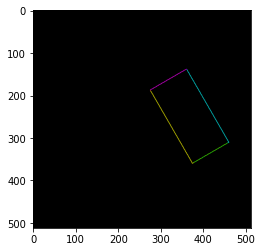

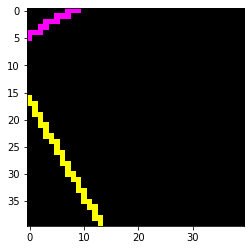

In [235]:
ors_rgb = data_utils.FlowToRgb(max_speed=0.2)(ors)
vis_utils.imshow(ors_rgb)
vis_utils.imshow(ors_rgb[:,:,180:220,280:320])

In [230]:
ors.amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.6667)

In [254]:
cims = fprop.coordinate_ims(1,0,[3,3],normalize=True).permute(0,3,1,2).view(1,2,9,1,1)
_n = lambda x: F.normalize(x, p=2, dim=1)
dots = torch.sum(_n(ors[:,:,None]) * _n(cims), dim=1)
dots.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 9, 512, 512])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


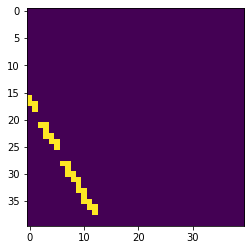

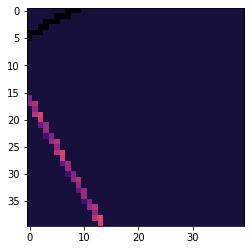

In [287]:
vis_utils.imshow(dots.argmax(1, True)[:,:,180:220,280:320] == 2)
vis_utils.imshow(torch.softmax(dots * 10, 1)[:,5,None,180:220,280:320], cmap='magma', vmin=0, vmax=1)

In [301]:
ors = fprop.estimate_boundary_orientations(rect_boundaries, rect, to_circle=True, beta=10.0)
ors = ors * rect_boundaries

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


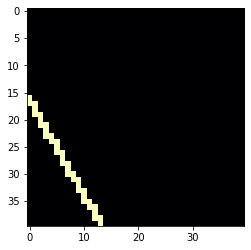

In [302]:
vis_utils.imshow(ors[:,[1,2,5],None,180:220,280:320].sum(1), cmap='magma', vmin=0, vmax=1)